In [81]:
# hide pakcage non critical warnings

import warnings

warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
import matplotlib.pyplot as plt

import scipy.io as sio

import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.nn.init as init

from tensorboard_logger import Logger

import os
import sys
import random
import pickle
import numpy as np
import pandas as pd


In [83]:
import devkit.api as dk

In [84]:
sys.path.append(
    os.path.abspath(
        os.path.join(os.path.dirname('__file__'), "..", "..")
    ))

In [85]:
import src.models.dcc.config as cfg

In [86]:
cfg.get_data_dir("cic")

'/home/egxxlch/dev/capacity_ai/proof-of-concept/data/raw/cic'

In [87]:
datadir = cfg.get_data_dir("cic")
outputdir = cfg.get_output_dir("cic")

In [88]:
datadir

'/home/egxxlch/dev/capacity_ai/proof-of-concept/data/raw/cic'

In [89]:
traindata = sio.loadmat(os.path.join(datadir, "traindata.mat"))

In [97]:
traindata

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon Aug 24 03:37:35 2020',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[5.20981327e-02, 4.26257476e-02, 4.26257476e-02, ...,
         6.94685727e-02, 6.64212257e-02, 4.79027070e-02],
        [4.25019488e-02, 5.31274341e-02, 5.31274341e-02, ...,
         1.90502114e-03, 2.31323997e-03, 1.22465647e-03],
        [4.73619401e-02, 4.26257476e-02, 5.68343289e-02, ...,
         6.19811937e-02, 3.91605310e-02, 3.98086086e-02],
        ...,
        [2.84171645e-02, 9.47238784e-03, 9.47238784e-03, ...,
         1.95526872e-02, 1.59537792e-02, 2.65988261e-02],
        [1.41673163e-01, 1.38131335e-01, 1.23964012e-01, ...,
         2.70785153e-01, 2.35678330e-01, 1.95536807e-01],
        [4.25019488e-02, 4.25019488e-02, 1.06254868e-01, ...,
         8.16437590e-04, 9.52510571e-04, 1.36072937e-04]]),
 'gtlabels': array([[array(['ho_SR'], dtype='<U5'),
         array(['access_cell_edge'], dtype='<U16'),
         array(['acc

In [90]:
pretrained = sio.loadmat(os.path.join(datadir, "pretrained.mat"))

In [91]:
pretrained

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon Aug 24 12:51:28 2020',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[5.2098133e-02, 4.2625748e-02, 4.2625748e-02, ..., 6.9468573e-02,
         6.6421226e-02, 4.7902707e-02],
        [4.2501949e-02, 5.3127434e-02, 5.3127434e-02, ..., 1.9050211e-03,
         2.3132400e-03, 1.2246565e-03],
        [4.7361940e-02, 4.2625748e-02, 5.6834329e-02, ..., 6.1981194e-02,
         3.9160531e-02, 3.9808609e-02],
        ...,
        [2.8417164e-02, 9.4723878e-03, 9.4723878e-03, ..., 1.9552687e-02,
         1.5953779e-02, 2.6598826e-02],
        [1.4167316e-01, 1.3813134e-01, 1.2396401e-01, ..., 2.7078515e-01,
         2.3567833e-01, 1.9553681e-01],
        [4.2501949e-02, 4.2501949e-02, 1.0625487e-01, ..., 8.1643759e-04,
         9.5251057e-04, 1.3607294e-04]], dtype=float32),
 'Z': array([[ 0.6284058 , -0.482436  , -0.31349948, ..., -2.8897371 ,
         -1.7002928 ,  0.73084915],
        [ 1.7847667 , -2.6461997 , -2.

In [92]:
traindata['X'].shape

(28302, 768)

In [93]:
with open(os.path.join(datadir, "pretrained.pkl"), 'rb') as f:
    pretrain_info = pickle.load(f)

In [94]:
pretrain_info.keys()

dict_keys(['Z', 'data'])

In [95]:
print(pretrain_info['data'].shape, pretrain_info['Z'].shape)

(28302, 768) (28302, 10)


In [96]:
print(pretrain_info['data'].shape, pretrain_info['Z'].shape)

(28302, 768) (28302, 10)


In [109]:
y_gt_pretrain = [traindata['gtlabels'].flatten()[i][0] for i in range(len(traindata['gtlabels'].flatten()))]

In [126]:
y_gt = np.asarray(y_gt_pretrain)

In [127]:
y_gt.shape

(28302,)

In [128]:
dict_label2int = dict(zip(np.unique(y_gt), range(len(np.unique(y_gt)))))

In [129]:
dict_label2int

{'access_cell_edge': 0,
 'access_resource': 1,
 'high_load': 2,
 'ho_SR': 3,
 'no_issue': 4,
 'normal': 5,
 'prach_interference': 6,
 'resource_limit': 7,
 'signaling_SR': 8,
 'signaling_load': 9,
 'uplink_interf': 10}

In [152]:
pd.Series(y_gt).value_counts()

normal                5000
ho_SR                 5000
no_issue              5000
access_cell_edge      5000
uplink_interf         3878
signaling_SR          1607
high_load             1488
resource_limit         749
prach_interference     427
signaling_load         108
access_resource         45
dtype: int64

In [130]:
y_gt_int = np.array([dict_label2int[i] for i in y_gt])

In [131]:
y_gt_int.shape

(28302,)

In [113]:
# y_gt_pretrain = pretrain_info['labels']
# y_gt_pretrain.shape

In [116]:
X = pretrain_info['data']
X.shape

(28302, 768)

In [117]:
Z = pretrain_info['Z']
Z.shape

(28302, 10)

In [118]:
Z

array([[ 0.6284058 , -0.482436  , -0.31349948, ..., -2.8897371 ,
        -1.7002928 ,  0.73084915],
       [ 1.7847667 , -2.6461997 , -2.0479085 , ..., -4.205451  ,
        -2.1042366 ,  0.1645584 ],
       [ 1.4684842 , -1.7507255 , -2.4657207 , ..., -5.6276054 ,
        -1.3444347 ,  1.379844  ],
       ...,
       [ 2.3369567 , -1.362673  , -3.1303904 , ..., -5.877703  ,
        -2.5265715 ,  0.94257617],
       [ 0.986661  , -2.5495763 ,  0.69853956, ..., -3.2479439 ,
        -3.4990146 ,  1.6677994 ],
       [-1.1744878 , -1.7648813 , -0.44135594, ..., -2.5294378 ,
        -0.33106697,  0.85347193]], dtype=float32)

In [119]:
ixs_selected = np.random.choice(len(Z),10000, replace=False)

# viz raw data [X]

In [123]:
y_gt_pretrain[ixs_selected].shape

(10000,)

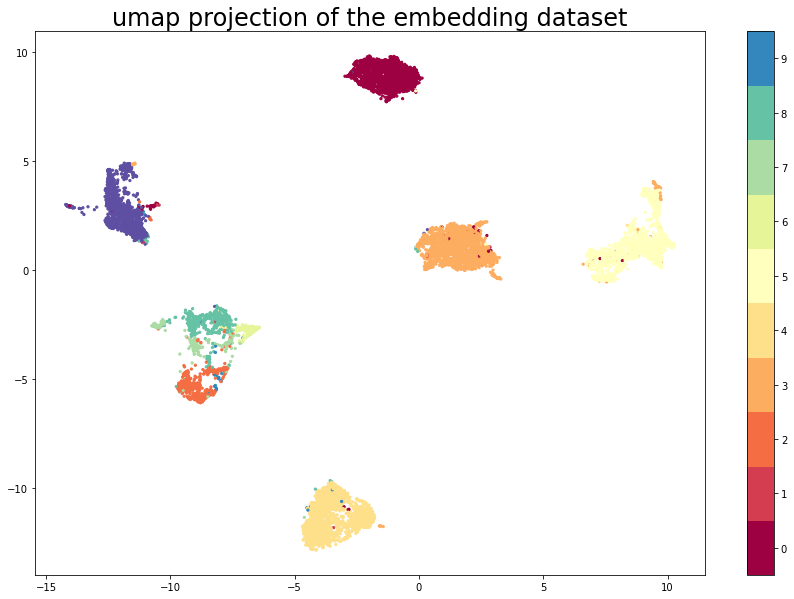

In [132]:
dk.data_viz(X=X[ixs_selected], y=y_gt_int[ixs_selected], method='umap')

In [80]:
dk.data_viz(X[ixs_selected], method='tsne')

KeyboardInterrupt: 

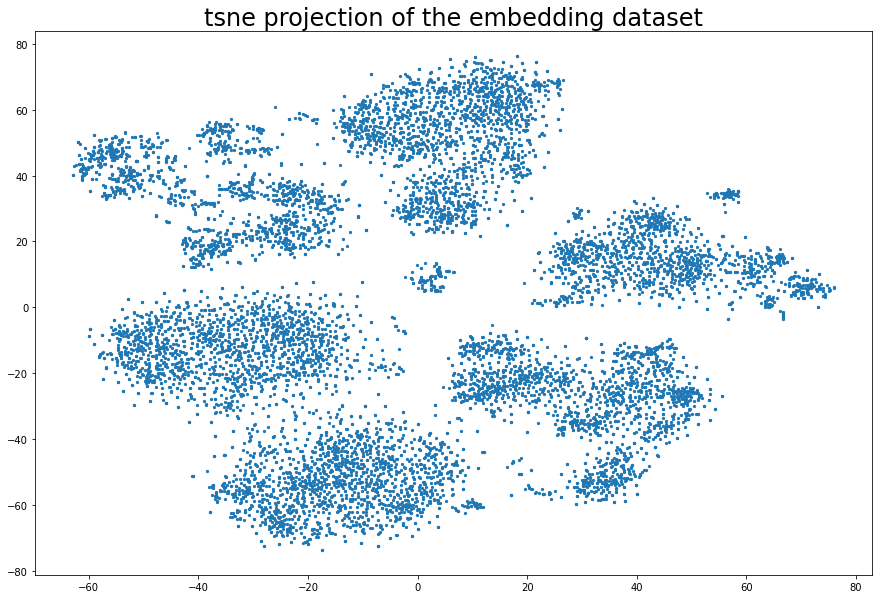

In [41]:
dk.data_viz(X[ixs_selected], method='tsne')

# viz embedding of sdae [Z]

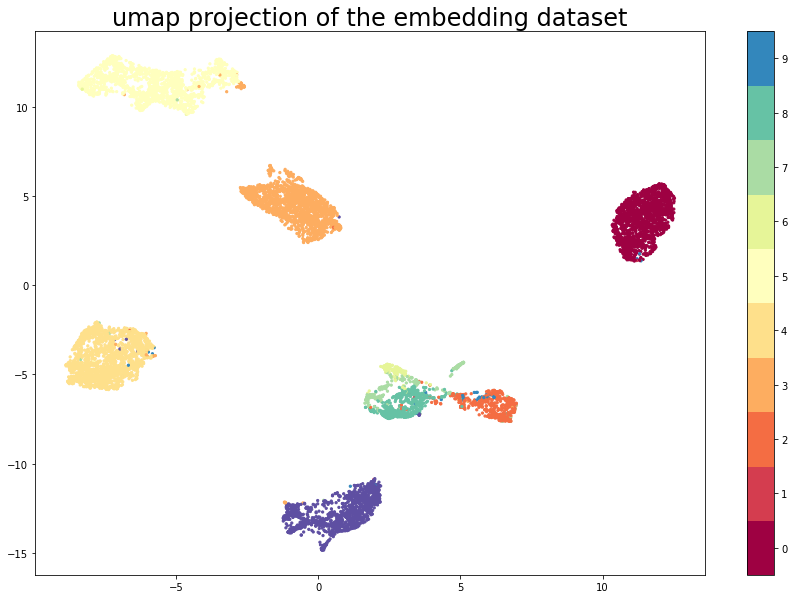

In [133]:
dk.data_viz(X=Z[ixs_selected], y=y_gt_int[ixs_selected], method='umap')

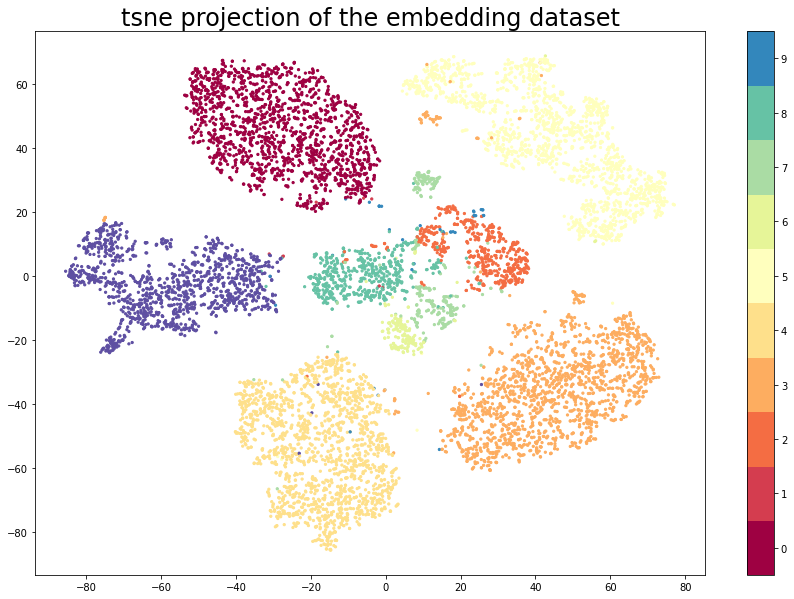

In [148]:
dk.data_viz(X=Z[ixs_selected], y=y_gt_int[ixs_selected], method='tsne')

# viz embedding of dcc [U]

## calculate U from checkpoint

In [139]:
from src.models.dcc.DCCLoss import DCCWeightedELoss, DCCLoss

In [22]:
datadir

'/Users/jasper/dev/mmc/data/raw/v1/dcc/mnist'

In [153]:
dcc_ckp = torch.load(os.path.join(datadir, "results/FTcheckpoint_420.pth.tar"))

In [154]:
dcc_ckp.keys()

dict_keys(['epoch', 'state_dict', 'criterion_state_dict', 'optimizer', 'sigma1', 'sigma2', 'lambda', 'delta', 'delta1', 'delta2'])

In [155]:
Z.shape

(28302, 10)

In [156]:
criterion2 = DCCLoss(Z.shape[0], Z.shape[1], Z, size_average=True)

In [157]:
criterion2.load_state_dict(dcc_ckp['criterion_state_dict'])

<All keys matched successfully>

In [158]:
U = criterion2.U.data.cpu().numpy()

In [159]:
U.shape

(28302, 10)

In [ ]:
dk.data_viz(X=U[ixs_selected], y=y_gt_int[ixs_selected], method='umap')

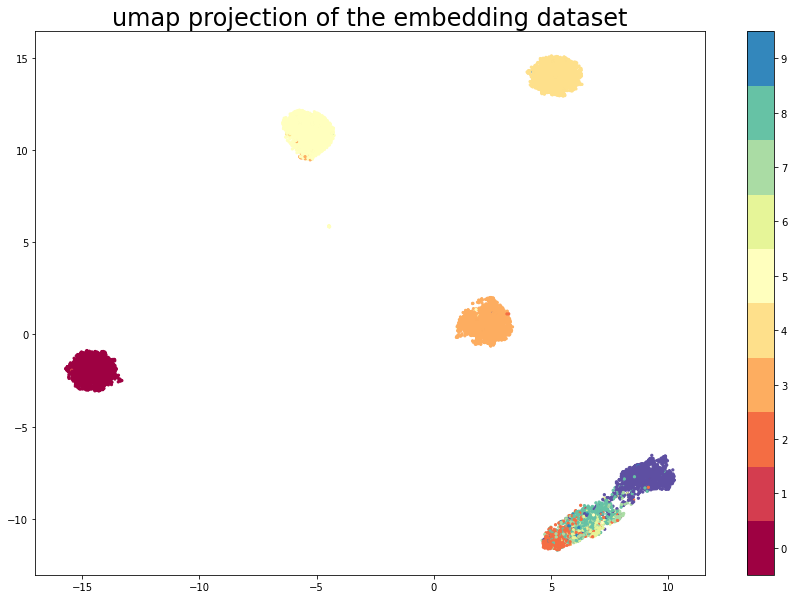

In [146]:
dk.data_viz(X=U[ixs_selected], y=y_gt_int[ixs_selected], method='umap')

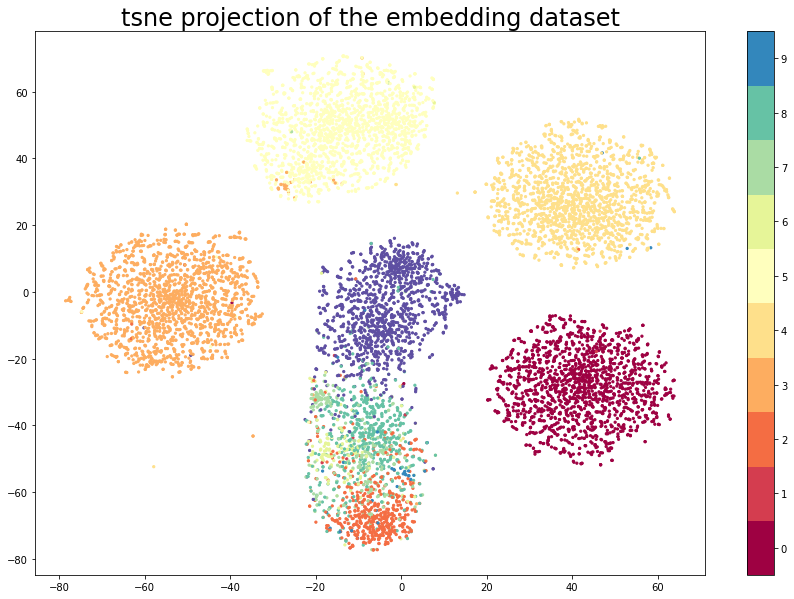

In [147]:
dk.data_viz(X=U[ixs_selected], y=y_gt_int[ixs_selected], method='tsne')

## get the U from final output

In [57]:
datadir

'/home/egxxlch/dev/capacity_ai/proof-of-concept/data/raw/cic'

In [149]:
dcc_res = sio.loadmat(os.path.join(datadir, "results/features.mat"))

FileNotFoundError: [Errno 2] No such file or directory: '/home/egxxlch/dev/capacity_ai/proof-of-concept/data/raw/cic/results/features.mat'

In [38]:
dcc_res.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Z', 'U', 'w', 'cluster'])

In [39]:
U_final = dcc_res['U']

In [25]:
y_gt = dcc_res['gtlabels'].flatten()

In [45]:
y_pred = dcc_res['cluster'].flatten()

In [46]:
y_pred.shape

(14346,)

In [28]:
assert (y_gt == y_gt_pretrain).all()

In [29]:
print(U_final.shape, y_gt.shape)

(70000, 10) (70000,)


## viz U

### umap

In [169]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

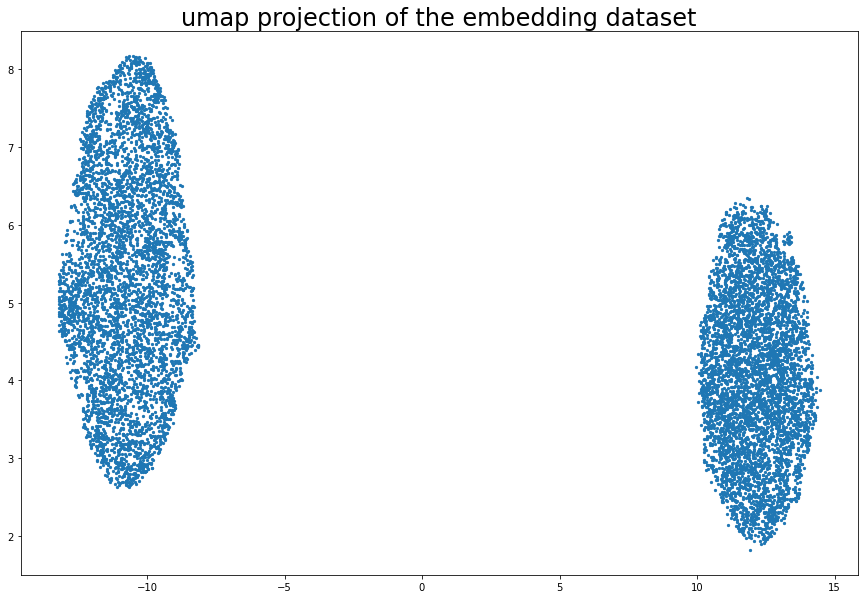

In [40]:
dk.data_viz(X=U_final[ixs_selected], method='umap')

### tsne

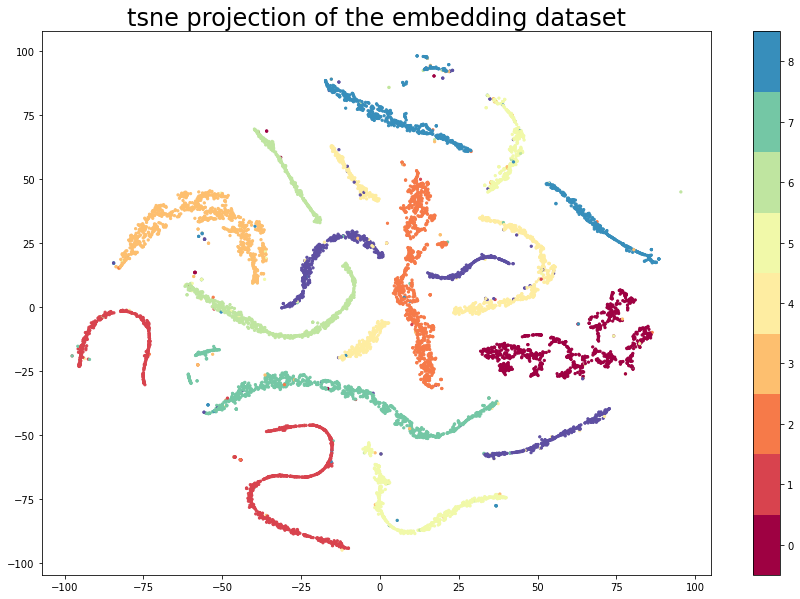

In [128]:
dk.data_viz(X=U_final[ixs_selected], y=y_gt[ixs_selected], method='tsne')

# viz images by cluster

In [41]:
def clustering_accuracy(gtlabels, labels):
    from scipy.optimize import linear_sum_assignment
    cost_matrix = []
    categories = np.unique(gtlabels)
    nr = np.amax(labels) + 1
    for i in np.arange(len(categories)):
        cost_matrix.append(np.bincount(labels[gtlabels == categories[i]], minlength=nr))
    cost_matrix = np.asarray(cost_matrix).T
    row_ind, col_ind = linear_sum_assignment(np.max(cost_matrix) - cost_matrix)

    return float(cost_matrix[row_ind, col_ind].sum()) / len(gtlabels)

In [167]:
clustering_accuracy(gtlabels=y_gt, labels=y_pred)

0.8599428571428571

In [163]:
plt.imshow??

In [43]:
import pandas as pd

In [54]:
pd.Series(y_pred).value_counts()

0       6688
177        2
3355       1
1306       1
7401       1
1258       1
3307       1
5360       1
7409       1
1266       1
3315       1
5368       1
7417       1
1274       1
3323       1
5376       1
7425       1
1194       1
3331       1
5384       1
7433       1
1290       1
3339       1
5392       1
7441       1
1298       1
3347       1
5400       1
7449       1
1282       1
        ... 
2708       1
4751       1
6798       1
653        1
2652       1
605        1
6750       1
4703       1
2660       1
613        1
6758       1
4711       1
2668       1
621        1
6766       1
4719       1
2676       1
629        1
6774       1
4727       1
2684       1
637        1
6782       1
4735       1
2692       1
645        1
6790       1
4743       1
2700       1
4090       1
Length: 7658, dtype: int64

In [47]:
lst_top_classes = pd.Series(y_pred).value_counts().index.tolist()[:10]
lst_bottom_classes = pd.Series(y_pred).value_counts().index.tolist()[-20:]

lst_ix_selected = [i for i,v in enumerate(y_pred) if v in lst_top_classes]

len(lst_ix_selected)

6698

In [33]:
28*28

784

In [49]:
X_2d = X.reshape(-1, 24, 40)

In [50]:
import devkit.api as dk

In [53]:
lst_top_classes

[0, 177, 3355, 1306, 7401, 1258, 3307, 5360, 7409, 1266]

total samples: 18 / 6688


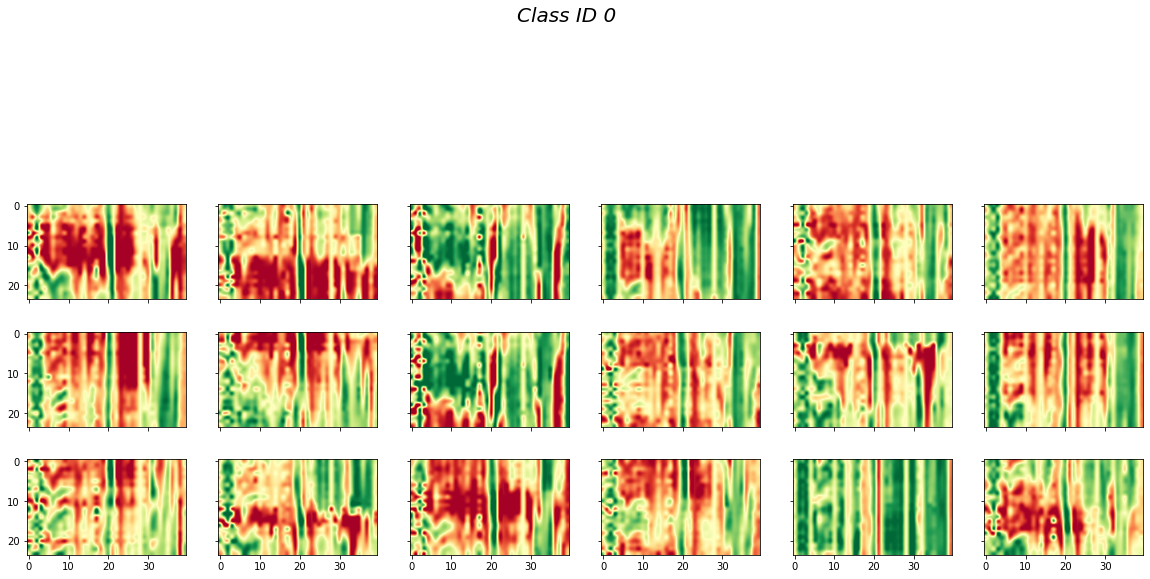

ValueError: Cannot take a larger sample than population when 'replace=False'

In [52]:
# default parameter values
def_vals = {'X' : None, 
            'arr_mse': None, 
            'arr_labels': None,
            'category': 'my_class', 
            'set_random': True,
            'nrows' : 3, 
            'ncols' :6
           }
# update dictionary key value

selcted_clusters = lst_top_classes
# selcted_clusters = np.unique(arr_label)
for cluster_id in selcted_clusters:
    class_indx = np.where(y_pred == cluster_id)[0]
    def_vals['X'] = X_2d[class_indx]
#     def_vals['arr_labels'] = y_gt[class_indx]
    def_vals['category'] = cluster_id
    dk.mgcMultiHeat(**def_vals)

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 2/70000


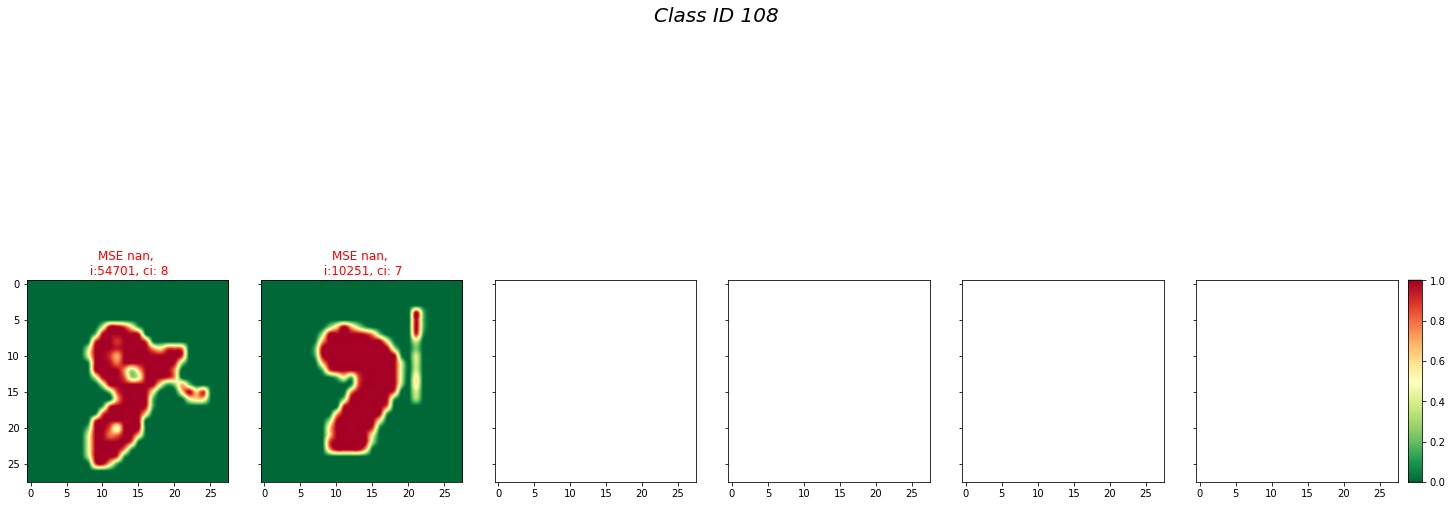

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


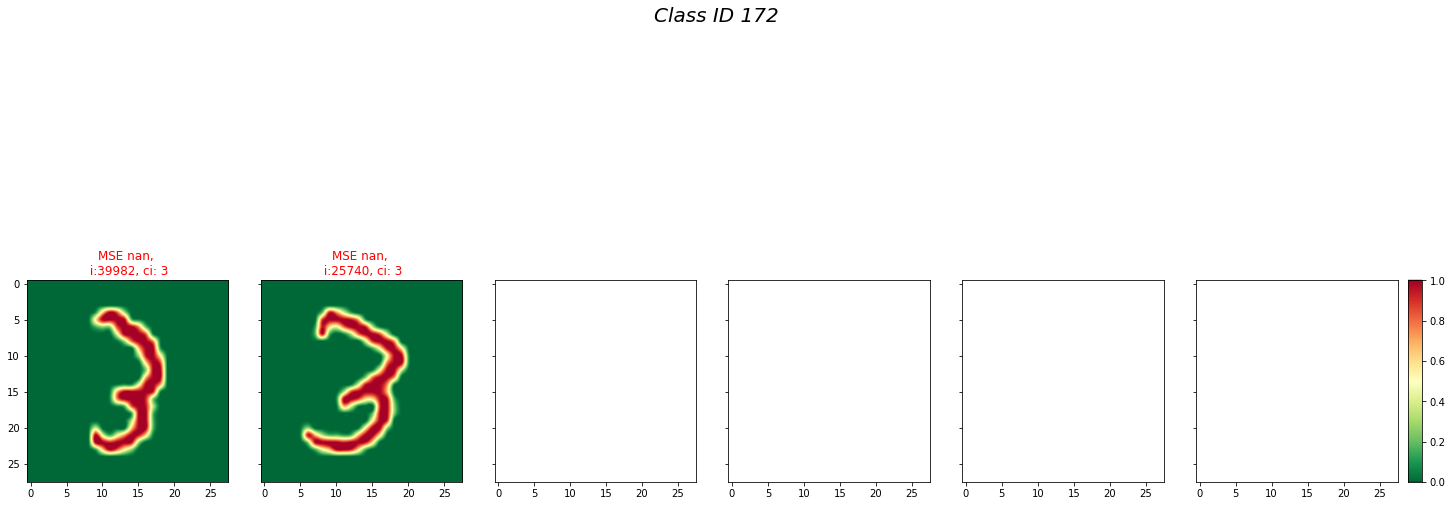

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


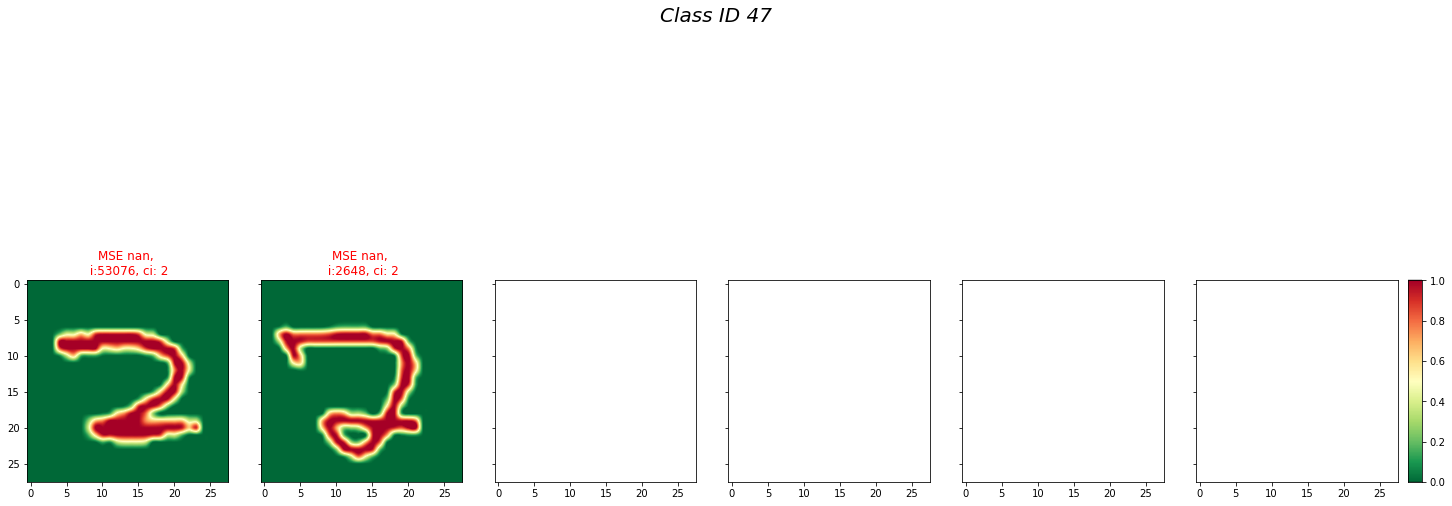

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


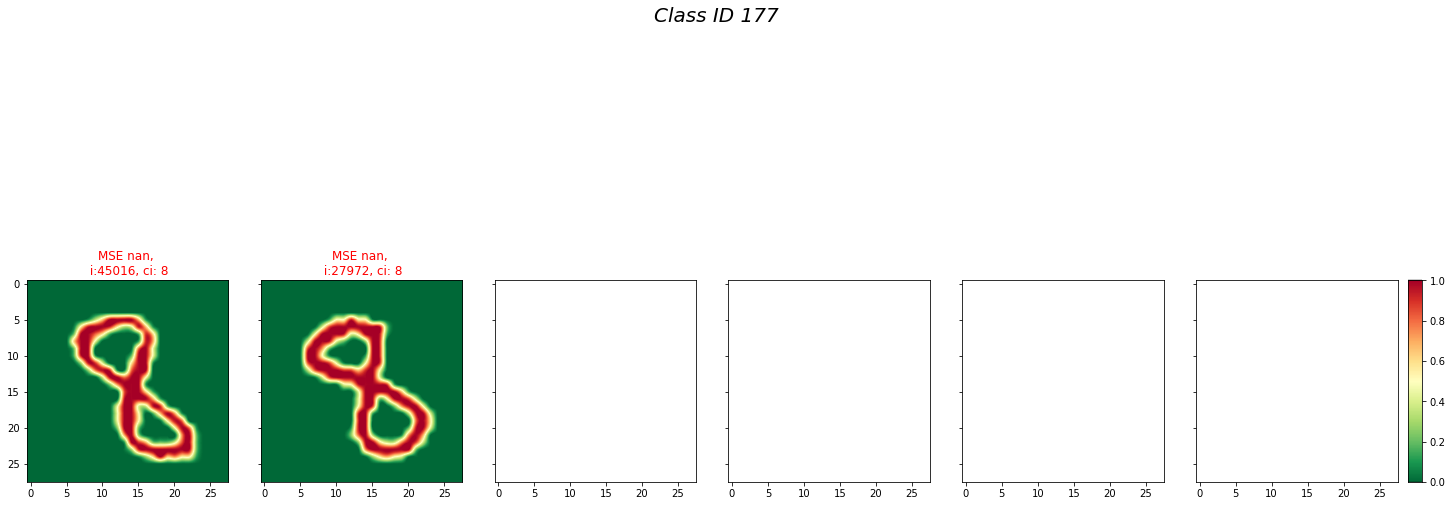

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


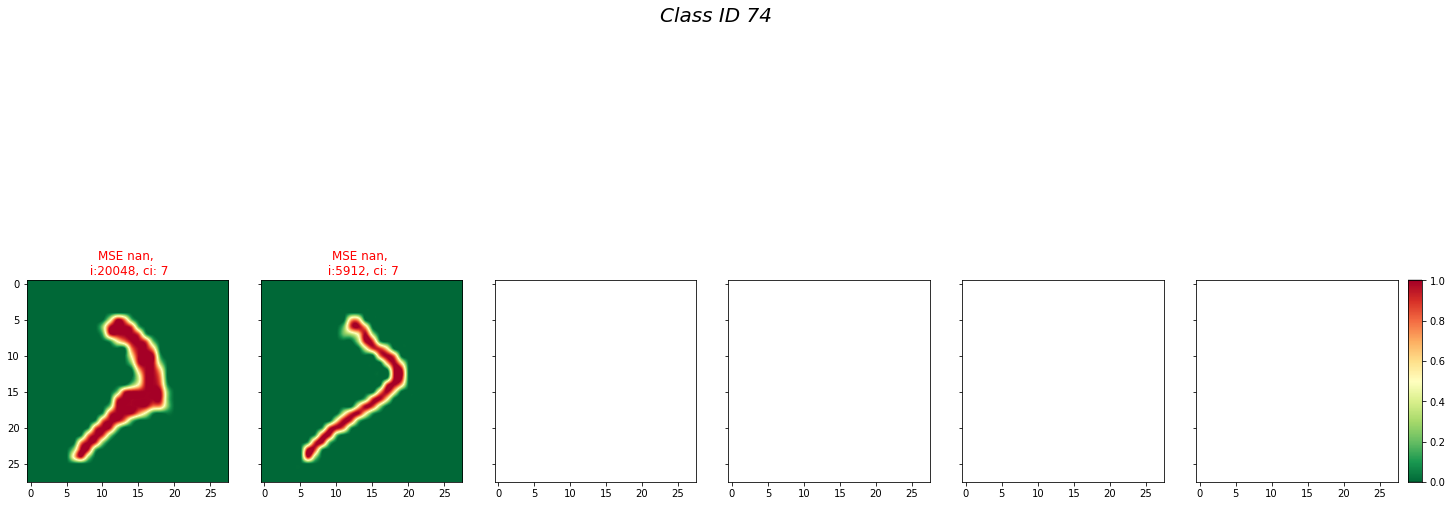

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


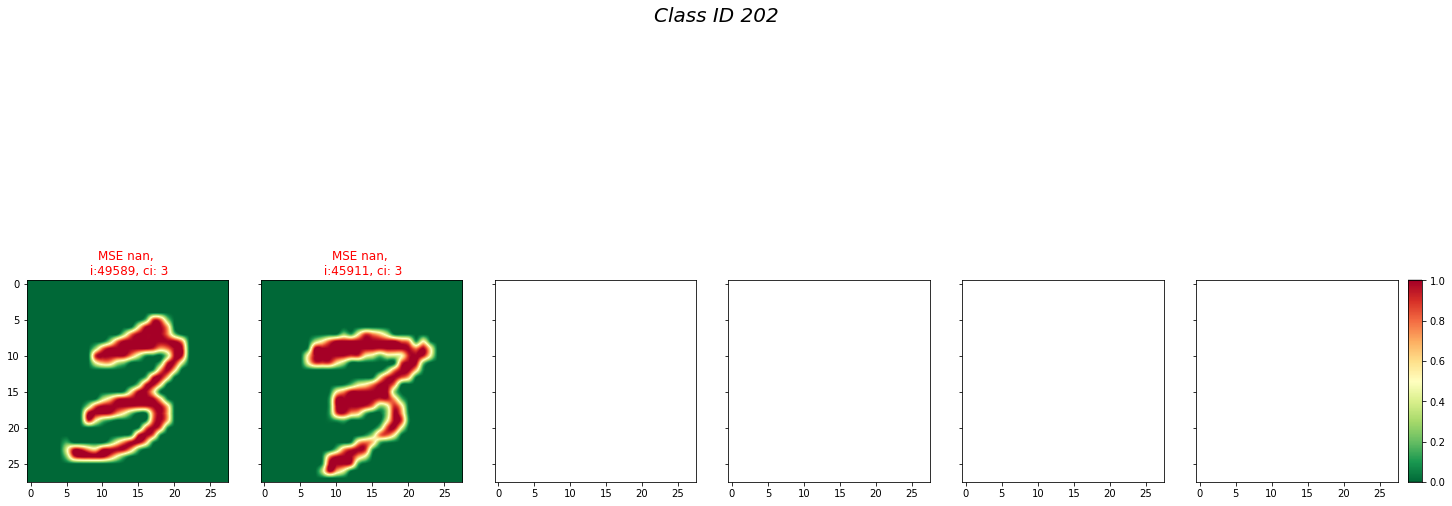

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 2/70000


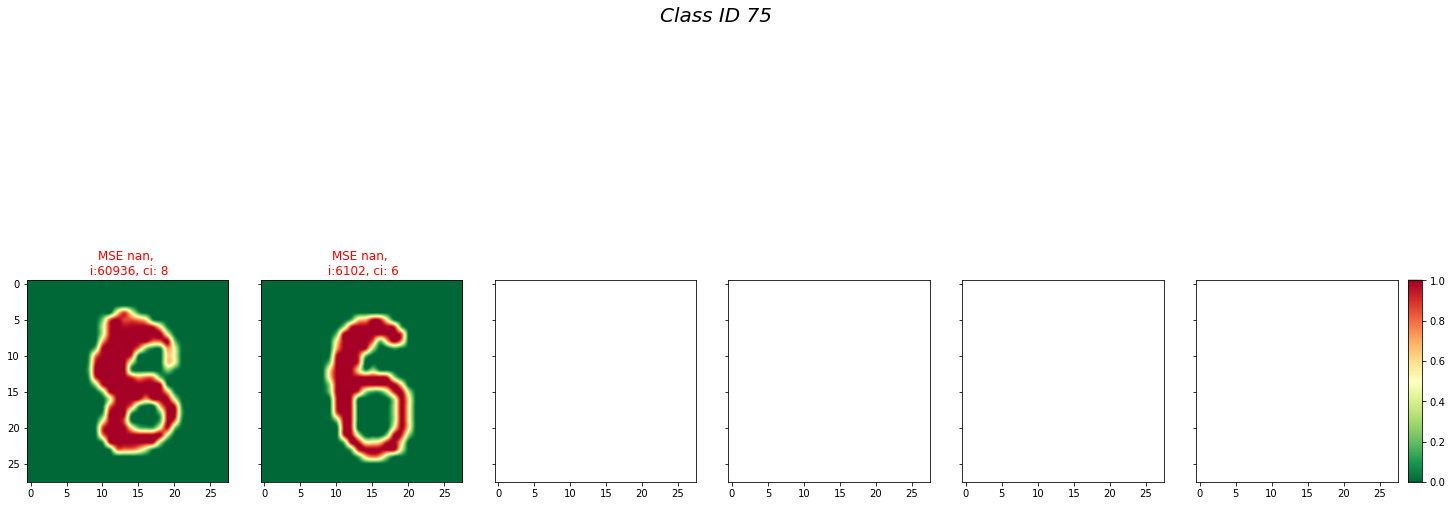

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 2/70000


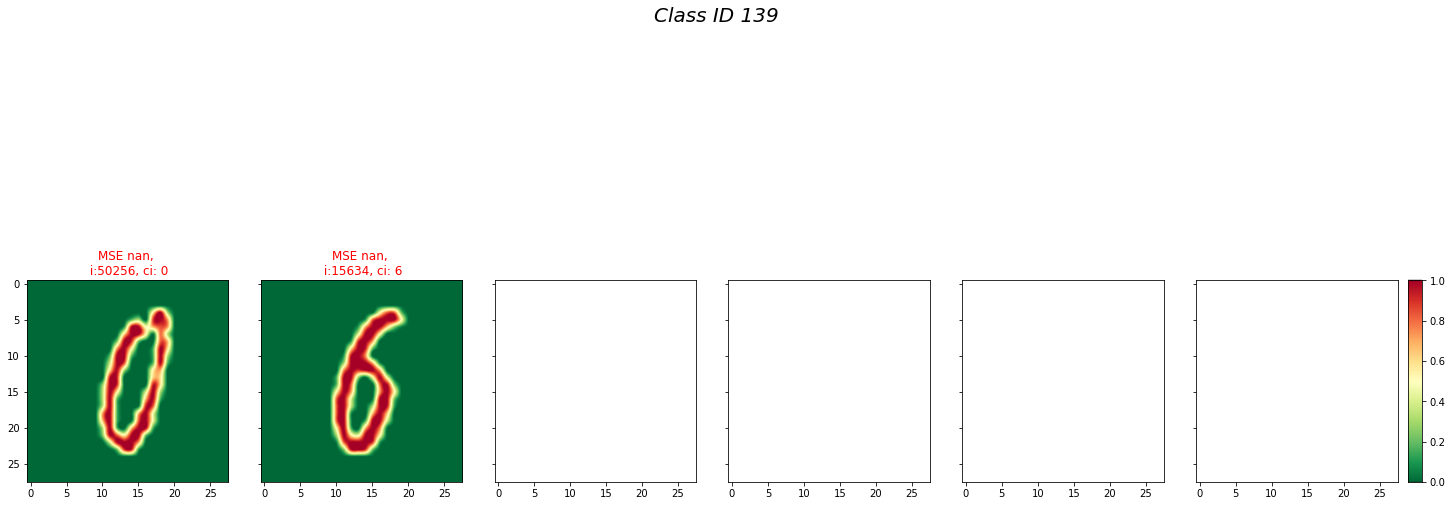

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


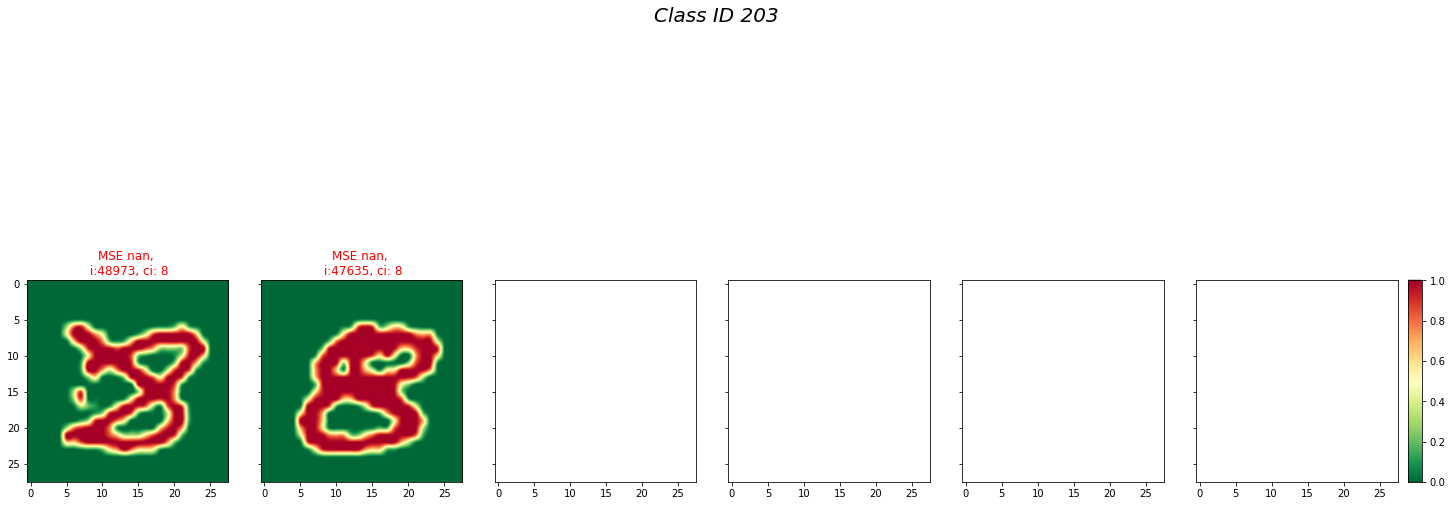

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 1/70000


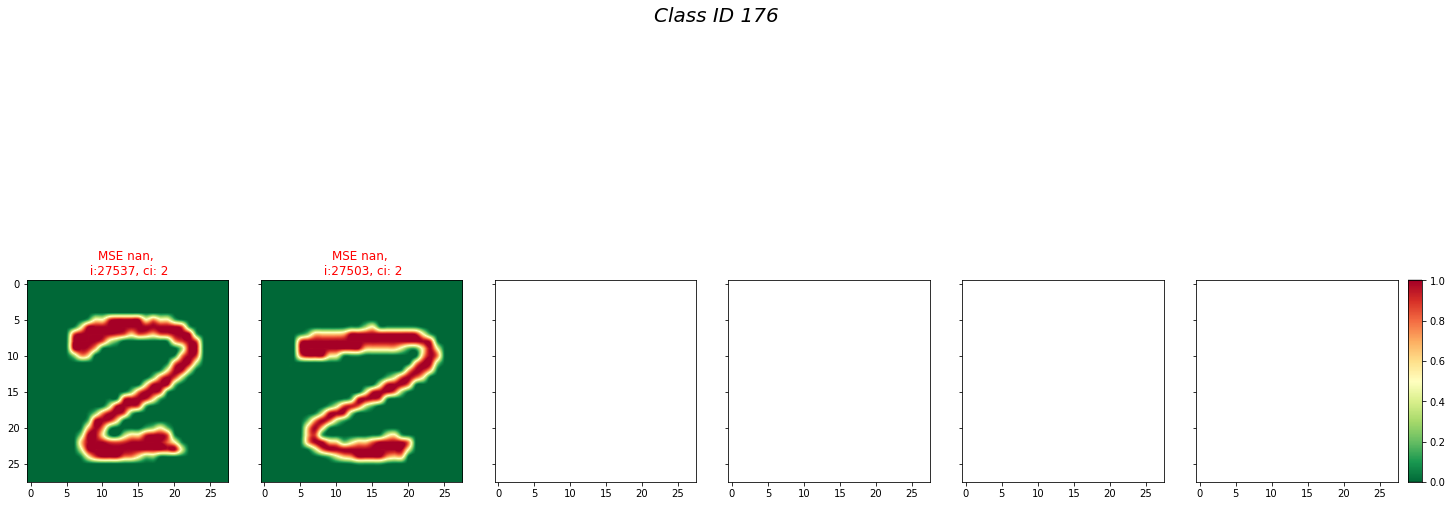

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 2/70000


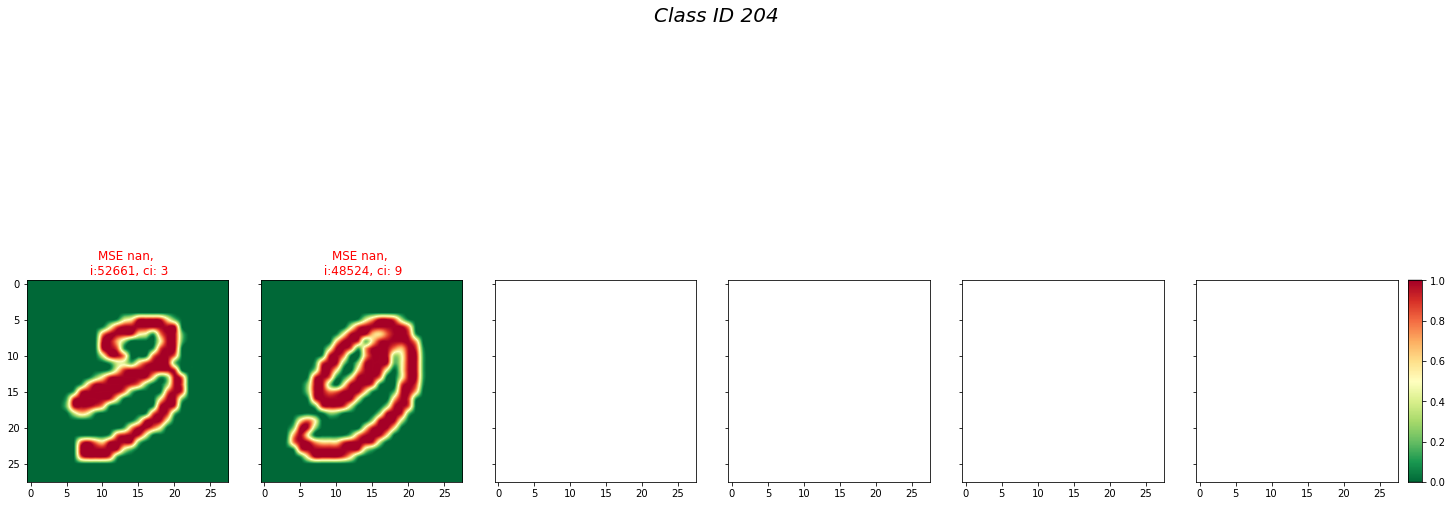

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 2/70000 cells
unique cell 2/70000


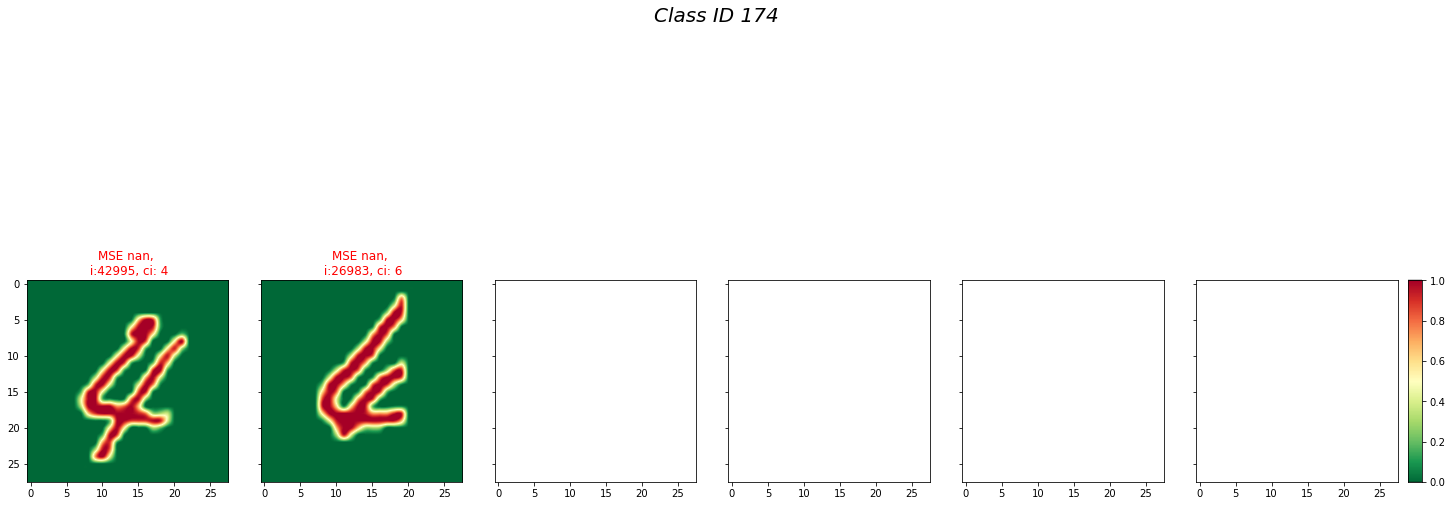

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


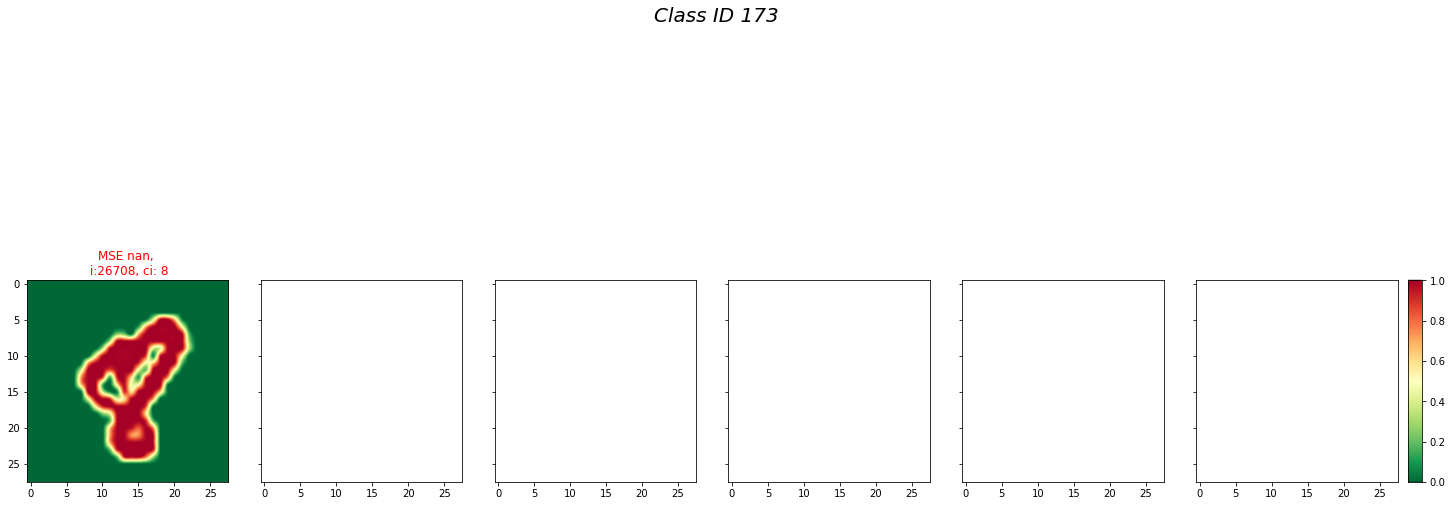

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


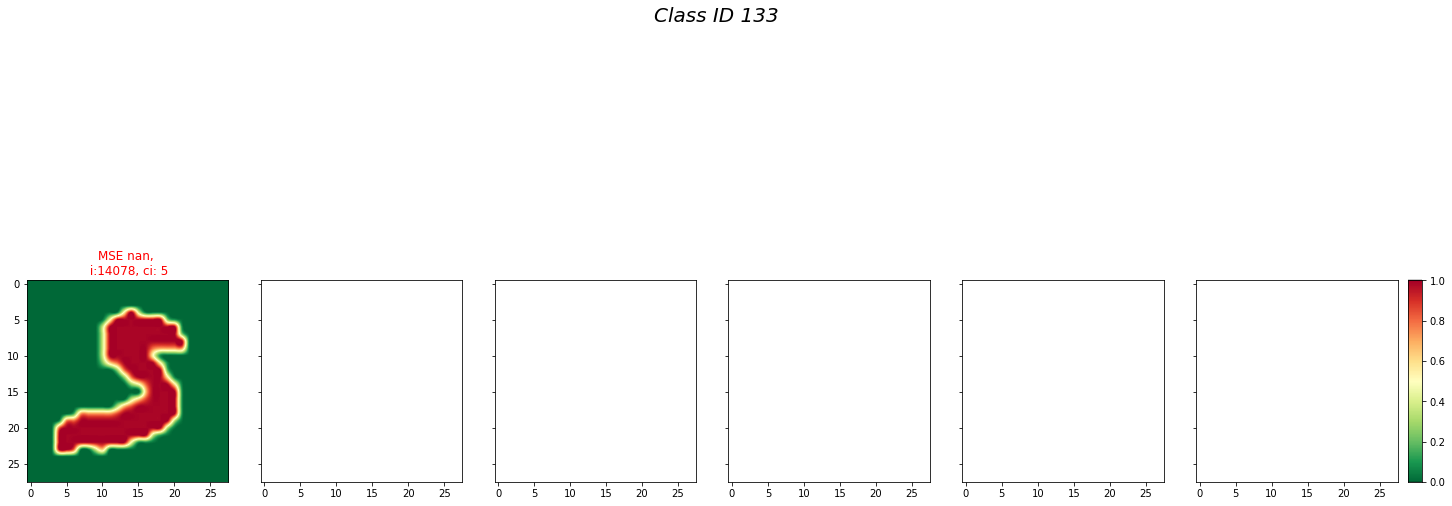

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


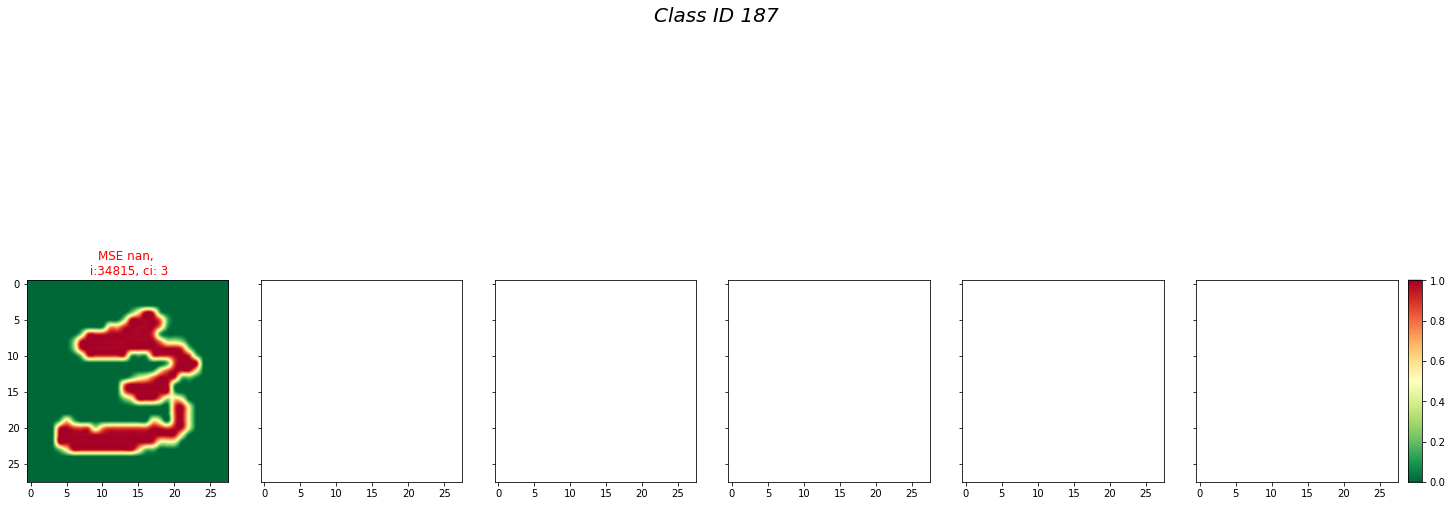

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


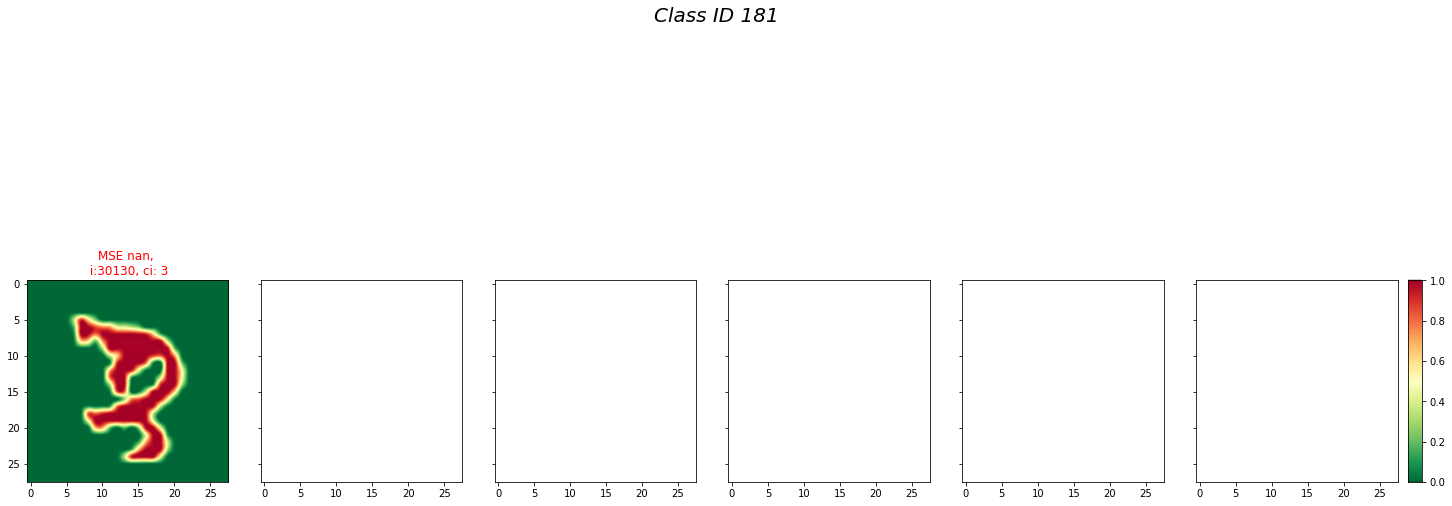

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


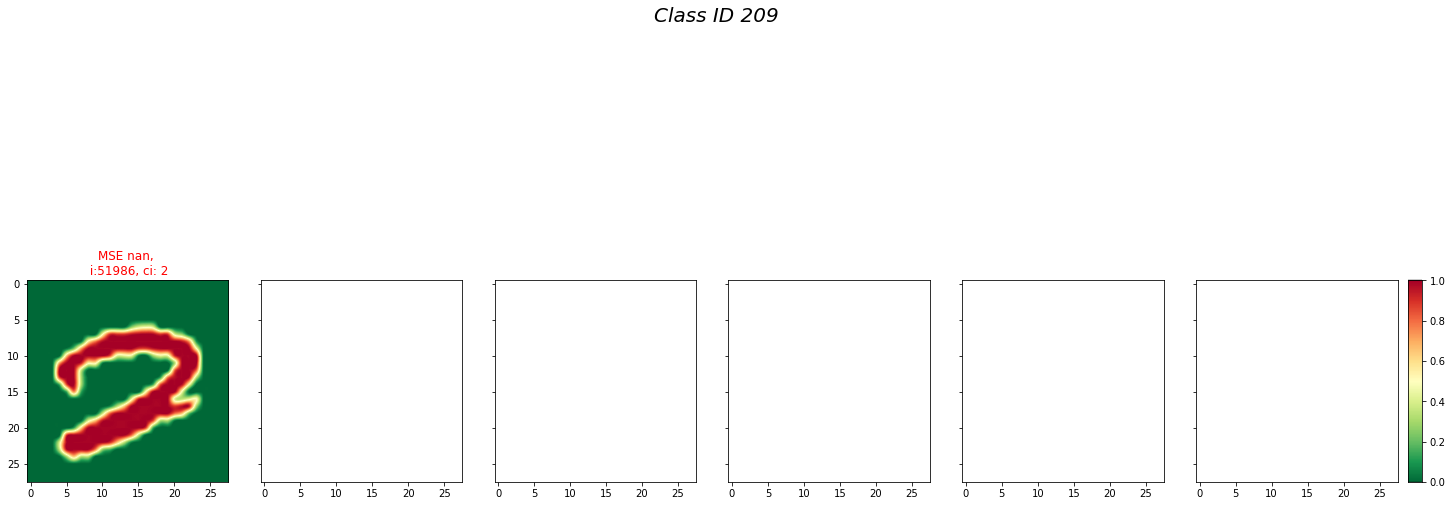

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


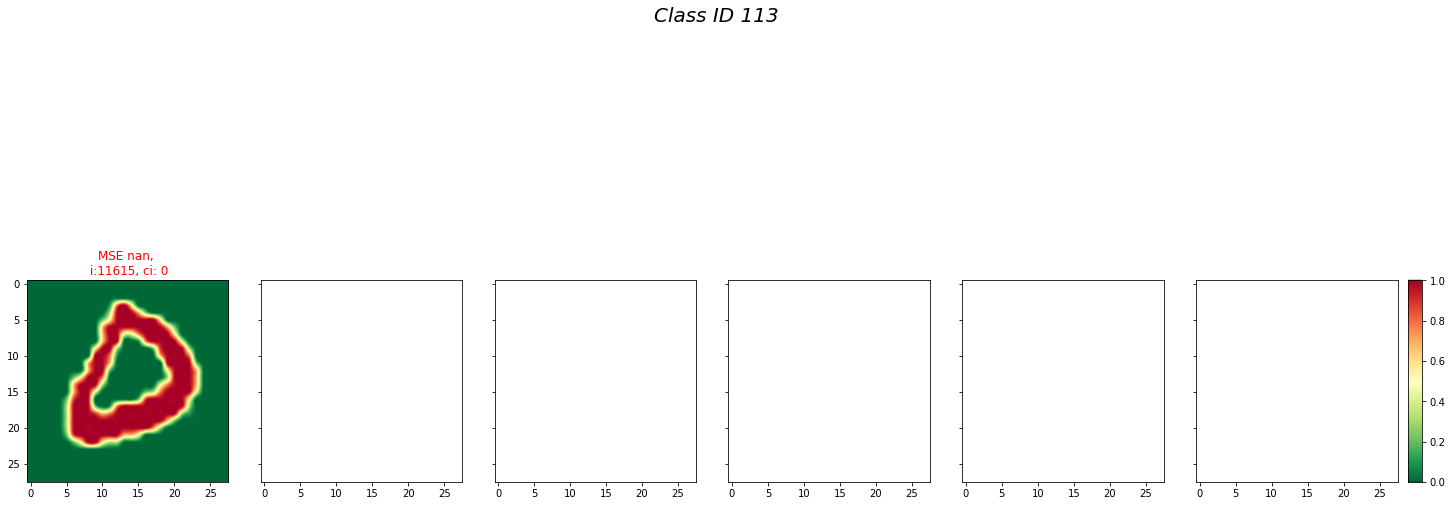

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


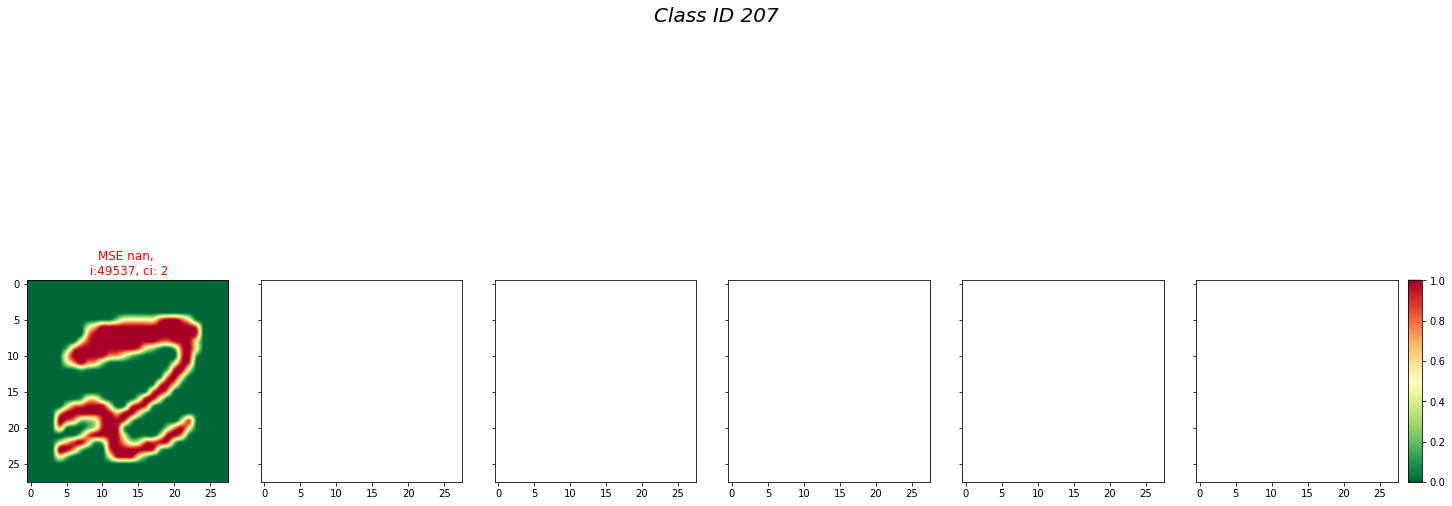

[nan nan nan ... nan nan nan]
<class 'numpy.ndarray'>
total cell: 1/70000 cells
unique cell 1/70000


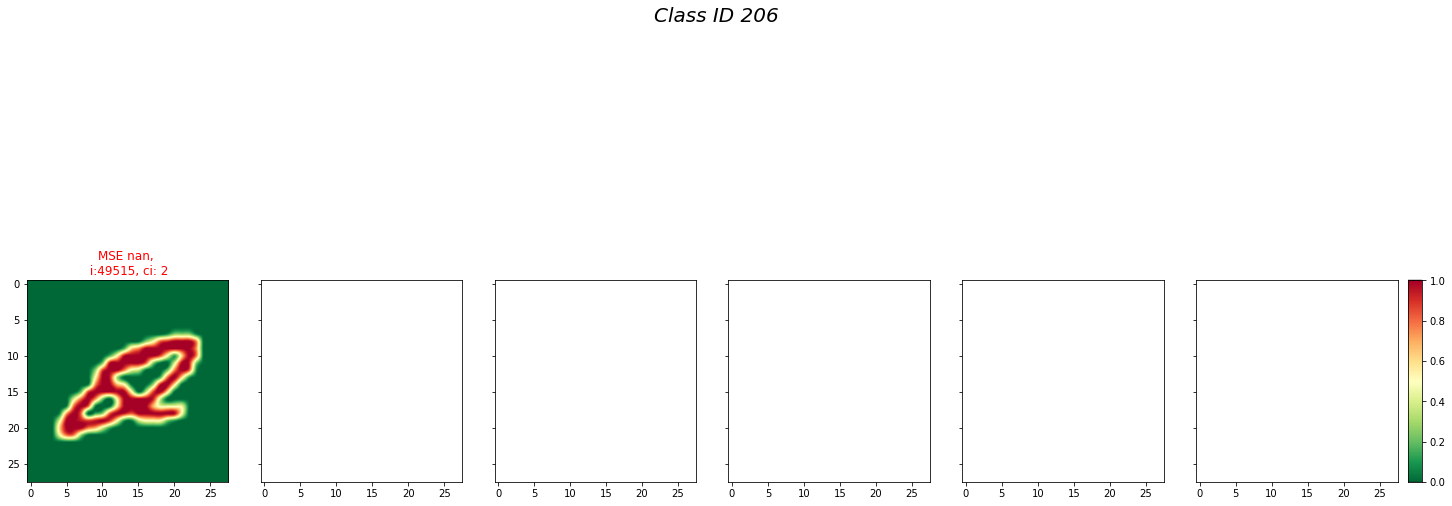

In [162]:
# default parameter values
def_vals = {'x_train' : X_2d, 
            'arr_mse': None, 
            'arr_mse_indx': None, 
            'cell_id': y_gt,
            'label_class': 'my_class', 
            'set_random': True,
            'rowx' : 3, 
            'colx' :6, 
            'img_rows' : 25, 
            'img_cols': 24, 
            'fname': 'plt_heat'}
# update dictionary key value

selcted_clusters = lst_bottom_classes
# selcted_clusters = np.unique(arr_label)
for cluster_id in selcted_clusters:
    class_indx = np.where(y_pred == cluster_id)[0]
    
    def_vals['label_class'] = cluster_id
    def_vals['arr_mse_indx'] = class_indx
    mgcMultiHeat_mse2(**def_vals)